In [1]:
import numpy as np
import great_expectations as ge
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import json
%matplotlib inline

In [2]:
## In the given problem, we expect that we have discrete values in the range 1-100 with a mean that is usually
## somewhat less than 50 and very fat tails.

# We choose the beta distribution with scale to provide a sample of data for this notebook, but real data
# would of coure be preferable and would allow the same procedure

a = np.random.uniform(1, 1.5, size=10)
b = np.random.uniform(1, 1.5, size=10)

beta = []
for k in range(len(a)):
    beta.append(np.ceil(np.random.beta(a[k], b[k], size=10000)*100))

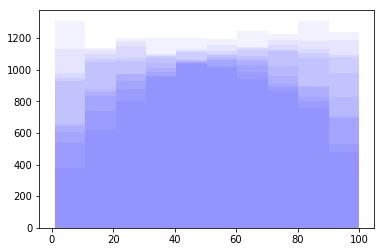

In [3]:
# Review the data manually

for k in range(10):
    plt.hist(beta[k], alpha=0.05, color='blue')

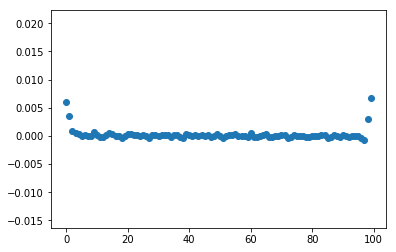

In [4]:
# Compute our "smoothness" statistic
mean_hist = np.histogram(np.array(beta), bins=range(0, 101))
grad = np.gradient(mean_hist[0] / 100000 )

# Note that we (based on this model) essentially expect large gradients around the 1st and last few elements.
# We might want to handle that by excluding them, we might want to add a mostly parameter, or we might want
# to create separate expectations for them.

plt.scatter(range(100), grad)

In [5]:
check_asset = ge.dataset.PandasDataset({"gradient": grad})

In [6]:
check_asset.expect_column_values_to_be_between('gradient', -.01, .01)

{'success': True,
 'result': {'element_count': 100,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [7]:
# We'll now repeat the sampling process to demonstrate data that passes our expectation,
# and as a mechanism to simply create a collection of (in this case identical) expectations

a_prime = np.random.uniform(1, 1.5, size=10)
b_prime = np.random.uniform(1, 1.5, size=10)

check_asset_prime = {}
for k in range(len(a_prime)):
    raw = np.ceil(np.random.beta(a_prime[k], b_prime[k], size=1000)*100)
    hist = np.histogram(raw, bins=range(0,101))
    grad = np.gradient(hist[0] / len(raw))
    check_asset_prime[str(k)] = grad

In [8]:
df = ge.dataset.PandasDataset(check_asset_prime)

In [9]:
res = ge.dataset.util.create_multiple_expectations(
    df,
    [str(k) for k in range(10)],
    'expect_column_values_to_be_between',
    min_value= -0.01,
    max_value= 0.01
)

In [10]:
# Finally, we repeat the process but adjust the data generating process to include an error (double counting)
# a subset of the data.

a_prime = np.random.uniform(1, 1.5, size=10)
b_prime = np.random.uniform(1, 1.5, size=10)

check_asset_broken  = {}
for k in range(len(a_prime)):
    beta_vals = np.ceil(np.random.beta(a_prime[k], b_prime[k], size=1000)*100)
    # In the estimated error condition, we observed extremely high counts for some value
    # (because it was being multiply counted)
    miscount_vals = np.array([np.random.choice(range(30,40), size=1)] * 100)
    raw = np.append(beta_vals, miscount_vals)
    hist = np.histogram(raw, bins=range(0, 101))
    grad = np.gradient(hist[0] / len(raw))
    check_asset_broken[str(k)] = grad

In [11]:
check_asset_broken = ge.dataset.PandasDataset(check_asset_broken)

In [12]:
res = check_asset_broken.validate(expectation_suite=df.get_expectation_suite(discard_failed_expectations=False))

In [13]:
print(json.dumps(res,indent=2))

{
  "results": [
    {
      "success": false,
      "result": {
        "element_count": 100,
        "missing_count": 0,
        "missing_percent": 0.0,
        "unexpected_count": 2,
        "unexpected_percent": 0.02,
        "unexpected_percent_nonmissing": 0.02,
        "partial_unexpected_list": [
          0.04727272727272727,
          -0.046818181818181814
        ]
      },
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "expectation_config": {
        "expectation_type": "expect_column_values_to_be_between",
        "kwargs": {
          "column": "0",
          "min_value": -0.01,
          "max_value": 0.01
        }
      }
    },
    {
      "success": false,
      "result": {
        "element_count": 100,
        "missing_count": 0,
        "missing_percent": 0.0,
        "unexpected_count": 2,
        "unexpected_percent": 0.02,
        "unexpected_percent_nonmissing": 0